In [1]:
import json

with open("../RQ2_tools_vulnerabilities.json",'r',encoding="UTF-8") as f:
    tool_swc_vul = json.load(f)

tools = tool_swc_vul.keys()

tool_vul_swc = {}

for tool, ids in tool_swc_vul.items():
    tool_vul_swc[tool] = {}
    for id, values in ids.items():
        for value in values:
            if value not in tool_vul_swc[tool]:
                tool_vul_swc[tool][value] = []
            tool_vul_swc[tool][value].append(id)

print(tool_vul_swc)

{'ethainter': {'AccessibleSelfdestruct': ['SWC-106'], 'TaintedValueSend': ['SWC-105'], 'TaintedSelfdestruct': ['SWC-105']}, 'madmax': {'OverflowLoopIterator': ['SWC-101']}, 'mythril': {'State access after external call': ['SWC-107'], 'Unprotected Selfdestruct': ['SWC-106'], 'Dependence on tx.origin': ['SWC-115'], 'Unprotected Ether Withdrawal': ['SWC-105'], 'Integer Arithmetic Bugs': ['SWC-101']}, 'semgrep': {'balancer-readonly-reentrancy-getpooltokens': ['SWC-107'], 'erc777-reentrancy': ['SWC-107'], 'erc721-reentrancy': ['SWC-107'], 'erc677-reentrancy': ['SWC-107'], 'compound-borrowfresh-reentrancy': ['SWC-107'], 'balancer-readonly-reentrancy-getrate': ['SWC-107'], 'curve-readonly-reentrancy': ['SWC-107'], 'accessible-selfdestruct': ['SWC-106'], 'compound-sweeptoken-not-restricted': ['SWC-105'], 'basic-arithmetic-underflow': ['SWC-101']}, 'slither': {'reentrancy-benign': ['SWC-107'], 'reentrancy-eth': ['SWC-107'], 'reentrancy-no-eth': ['SWC-107'], 'suicidal': ['SWC-106'], 'tx-origin':

# count number to csv

In [3]:
import pandas as pd

for tool in tools:
    if tool != "ethainter": continue
    data_path = './{0}/mainnet/merged_file.csv'.format(tool)
    df = pd.read_csv(data_path, usecols=['address', 'vulnerability', 'compiler'])
    vulnerabilities = tool_vul_swc[tool].keys()

    swc_ids = []
    for vul in vulnerabilities:
        swc_ids.append(tool_vul_swc[tool][vul][0])
    
    df_filtered = df[df['vulnerability'].isin(vulnerabilities)]
    
    df_filtered = df_filtered.drop_duplicates()
    
    df_filtered['SWC_ID'] = df_filtered['vulnerability'].map(
    dict(zip(vulnerabilities, swc_ids))
    )
    
    df_filtered.to_csv('./contract_level/RQ2_{0}_five_swc_id.csv'.format(tool), index=False)
    print(tool)
    print(df_filtered['vulnerability'].unique())

ethainter
['AccessibleSelfdestruct' 'TaintedValueSend' 'TaintedSelfdestruct']


In [4]:
import pandas as pd

csv_files = []
for tool in tools:
    csv_files.append('./contract_level/RQ2_{0}_five_swc_id.csv'.format(tool))

SWCIDs = ["SWC-107", "SWC-106", "SWC-115", "SWC-105", "SWC-101"]
versions = ["4", "5", "6", "7", "8"]

data_count = list()

for tool, file in zip(tools, csv_files):
    tool_data = pd.read_csv(file)
    tool_data['compiler'] = tool_data['compiler'].str.split('.').str[1]
    for i in SWCIDs:
        for j in versions:
            filtered_data = tool_data[(tool_data['SWC_ID'] == i) & (tool_data['compiler'] == j)]
            count = filtered_data.shape[0]
            data_count.append([tool, i, j, count])

df = pd.DataFrame(data_count, columns=['Tool', 'SWC_ID', 'Compiler', 'Count'])

def calculate_ratio(row):
    if row['Compiler'] == "4":
        return row['Count'] / 31972
    elif row['Compiler'] == "5":
        return row['Count'] / 10944
    elif row['Compiler'] == "6":
        return row['Count'] / 20827
    elif row['Compiler'] == "7":
        return row['Count'] / 10060
    elif row['Compiler'] == "8":
        return row['Count'] / 177537
    else:
        return None

df['Ratio'] = df.apply(calculate_ratio, axis=1)

df.to_csv('RQ2_graph_data_count.csv', index=False)

# draw graph

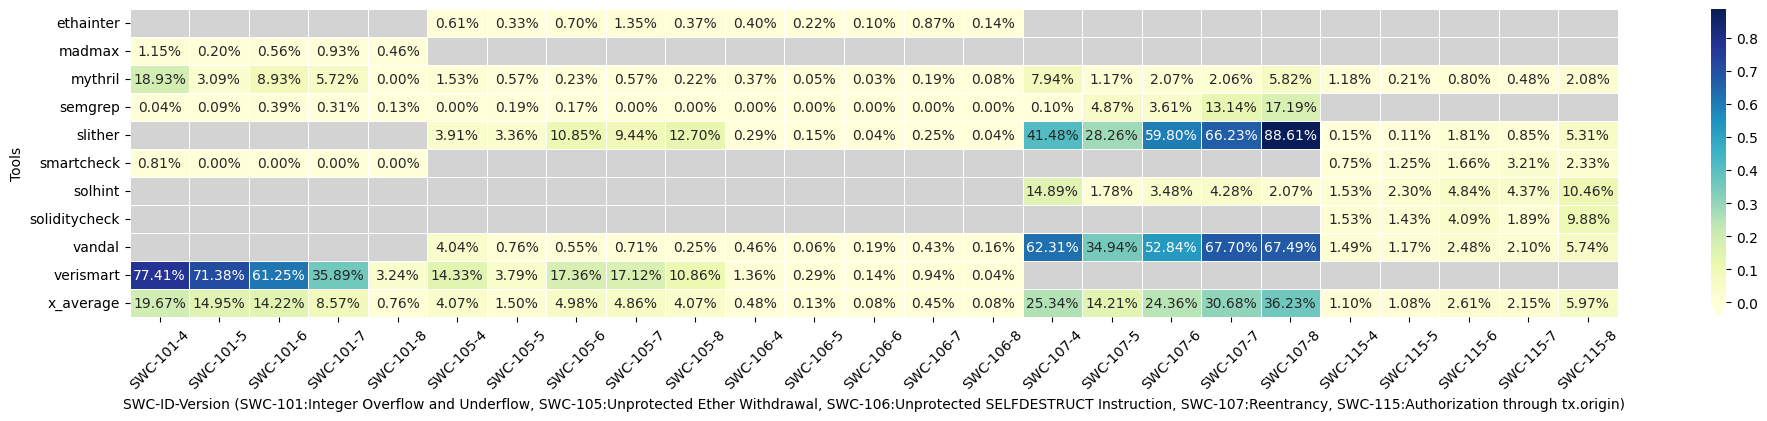

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi

import json

with open("../RQ2_tools_vulnerabilities.json",'r',encoding="UTF-8") as f:
    tool_swc_vul = json.load(f)

tools = tool_swc_vul.keys()

df = pd.read_csv('./contract_level/RQ2_graph_data_count.csv')
SWCIDs = ["SWC-107", "SWC-106", "SWC-115", "SWC-105", "SWC-101"]
# versions = ["4", "5", "6", "7", "8"]
versions = [4,5,6,7,8]

for tool in tools:
    for i in SWCIDs:
        if tool_swc_vul[tool][i]==[]:
            for j in versions:
                df.loc[(df['Tool'] == tool) & (df['SWC_ID'] == i) & (df['Compiler'] == j), 'Ratio'] = None

def mean_without_nan(values):
    valid_values = values.dropna()  # remove NaN value
    if len(valid_values) == 0:
        return np.nan
    else:
        return valid_values.mean()

grouped = df.groupby(['SWC_ID', 'Compiler'], as_index=False)['Ratio'].agg(mean_without_nan)
grouped["Tool"] = "x_average"
grouped["Count"] = None
df = pd.concat([grouped,df],axis=0)

pivot_table = df.pivot_table(index='Tool', columns=['SWC_ID', 'Compiler'], values='Ratio')
plt.figure(figsize=(24, 4))

cmap = sns.color_palette("YlGnBu", as_cmap=True)
cmap.set_bad('lightgrey')

sns.heatmap(pivot_table, cmap=cmap, annot=True, fmt='.2%', linewidths=0.5, cbar_kws={'extend': 'min'}, mask=pivot_table.isna())

plt.xlabel('SWC-ID-Version (SWC-101:Integer Overflow and Underflow, SWC-105:Unprotected Ether Withdrawal, SWC-106:Unprotected SELFDESTRUCT Instruction, SWC-107:Reentrancy, SWC-115:Authorization through tx.origin)')
plt.xticks(rotation=45)
plt.ylabel('Tools')
plt.show()